# Face recognition example using eigenfaces and SVMs

The skeleton of the following source code is adapted from this [sklearn tutorial link](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-download-auto-examples-applications-plot-face-recognition-py). At the end you can find an exercise to complete. 

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW: http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB).



In [28]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context


Download the data, if not already on disk and load it as numpy arrays



In [29]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


Split into a training set and a test and keep 25% of the data for testing.



In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): unsupervised feature extraction / dimensionality reduction



In [31]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 3.799s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.241s


Train a SVM classification model



In [32]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 4.672s
Best estimator found by grid search:
SVC(C=8469.168518404016, class_weight='balanced', gamma=0.005754445367870485)


Quantitative evaluation of the model quality on the test set



Predicting people's names on the test set
done in 0.038s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.54      0.70        13
     Colin Powell       0.78      0.90      0.84        60
  Donald Rumsfeld       0.89      0.59      0.71        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       1.00      0.80      0.89        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.85       322
        macro avg       0.92      0.73      0.80       322
     weighted avg       0.87      0.85      0.85       322



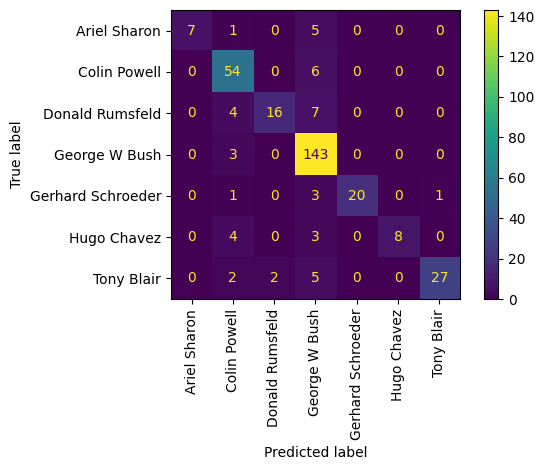

In [33]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Qualitative evaluation of the predictions using matplotlib



In [34]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot the result of the prediction on a portion of the test set



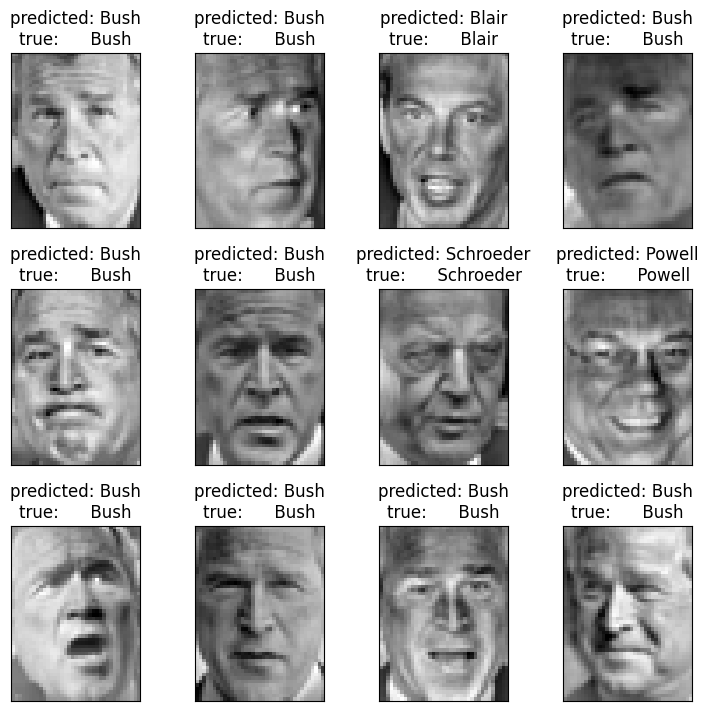

In [35]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

plot the gallery of the most significative eigenfaces



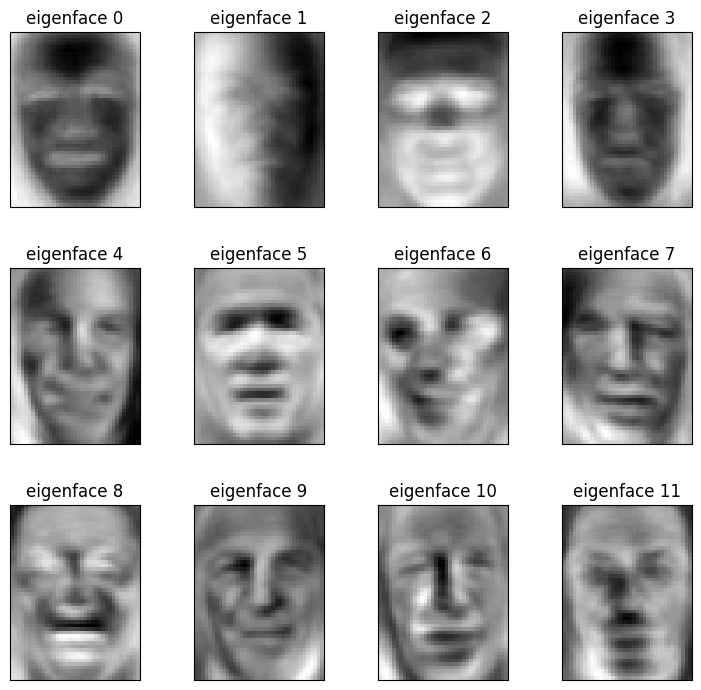

In [36]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Exercise

-  How much of the variance is explained by the first and second principal components? For this, you can use the function pca.explained_variance_ratio_[index]

- Now, let's experiment with keeping different numbers of principal components. While ideally, adding components should provide us additional data to improve our performance, it is possible that we end up at a complexity where we overfit.

Extracting the top 10 eigenfaces from 966 faces
Best estimator found by grid search:
SVC(C=74628.60785098441, class_weight='balanced', gamma=0.0004664047698602136)
                   precision    recall  f1-score   support

     Ariel Sharon       0.13      0.46      0.20        13
     Colin Powell       0.51      0.50      0.50        60
  Donald Rumsfeld       0.38      0.48      0.43        27
    George W Bush       0.81      0.51      0.63       146
Gerhard Schroeder       0.25      0.32      0.28        25
      Hugo Chavez       0.15      0.27      0.19        15
       Tony Blair       0.40      0.33      0.36        36

         accuracy                           0.46       322
        macro avg       0.37      0.41      0.37       322
     weighted avg       0.57      0.46      0.49       322



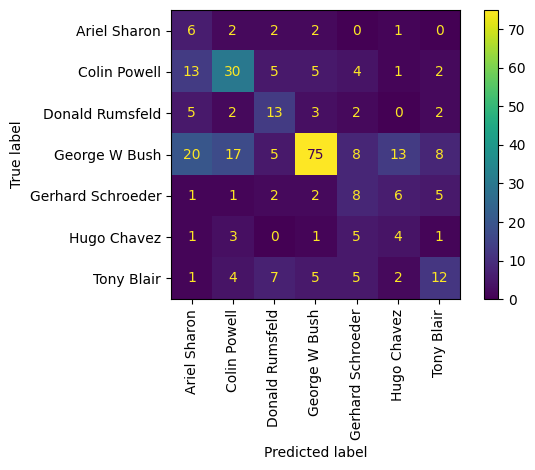

Extracting the top 15 eigenfaces from 966 faces
Best estimator found by grid search:
SVC(C=4797.925857477245, class_weight='balanced', gamma=0.07704228348105999)
                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.54      0.50        13
     Colin Powell       0.78      0.70      0.74        60
  Donald Rumsfeld       0.41      0.56      0.47        27
    George W Bush       0.75      0.77      0.76       146
Gerhard Schroeder       0.50      0.44      0.47        25
      Hugo Chavez       0.64      0.47      0.54        15
       Tony Blair       0.45      0.42      0.43        36

         accuracy                           0.65       322
        macro avg       0.57      0.55      0.56       322
     weighted avg       0.66      0.65      0.65       322



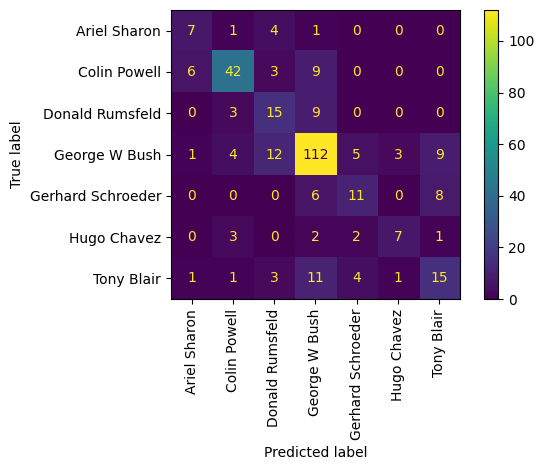

Extracting the top 25 eigenfaces from 966 faces
Best estimator found by grid search:
SVC(C=15415.298898236328, class_weight='balanced', gamma=0.03162500367891764)
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.72      0.67      0.69        27
    George W Bush       0.86      0.90      0.88       146
Gerhard Schroeder       0.78      0.56      0.65        25
      Hugo Chavez       0.83      0.67      0.74        15
       Tony Blair       0.74      0.72      0.73        36

         accuracy                           0.81       322
        macro avg       0.77      0.73      0.75       322
     weighted avg       0.81      0.81      0.81       322



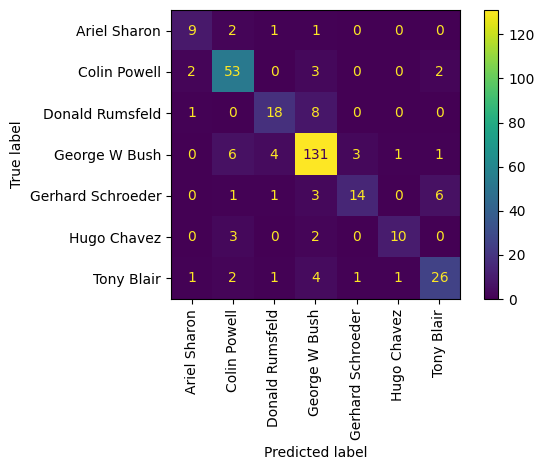

Extracting the top 50 eigenfaces from 966 faces
Best estimator found by grid search:
SVC(C=3511.9782615406657, class_weight='balanced', gamma=0.024627854823367844)
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.69      0.82        13
     Colin Powell       0.83      0.92      0.87        60
  Donald Rumsfeld       0.89      0.59      0.71        27
    George W Bush       0.81      0.95      0.88       146
Gerhard Schroeder       0.81      0.68      0.74        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.93      0.72      0.81        36

         accuracy                           0.84       322
        macro avg       0.90      0.74      0.80       322
     weighted avg       0.85      0.84      0.84       322



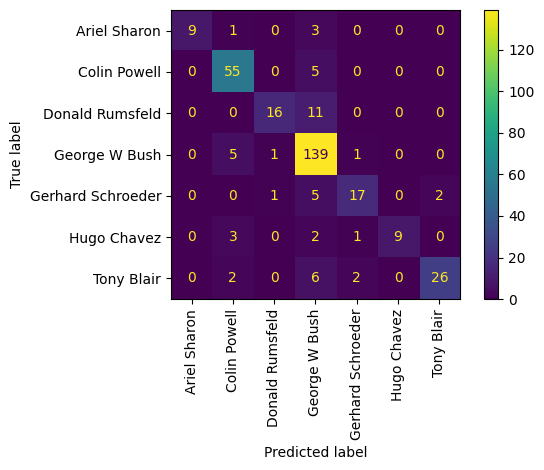

Extracting the top 100 eigenfaces from 966 faces
Best estimator found by grid search:
SVC(C=2451.8653699511515, class_weight='balanced', gamma=0.0049138405149881425)
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.77      0.90      0.83        60
  Donald Rumsfeld       0.75      0.67      0.71        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.89      0.67      0.76        36

         accuracy                           0.84       322
        macro avg       0.80      0.74      0.76       322
     weighted avg       0.84      0.84      0.83       322



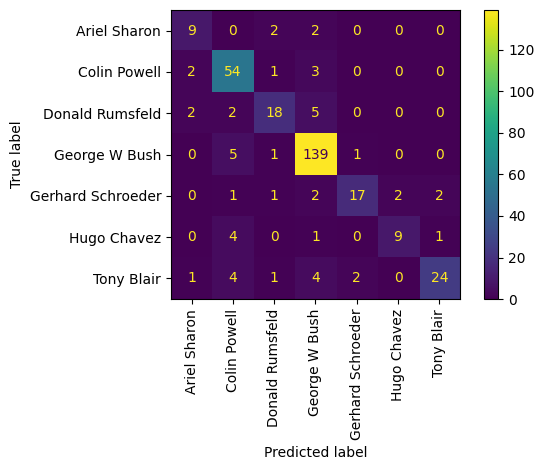

Extracting the top 250 eigenfaces from 966 faces
Best estimator found by grid search:
SVC(C=8640.257104310585, class_weight='balanced', gamma=0.0019499806481106034)
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.79      0.90      0.84        60
  Donald Rumsfeld       1.00      0.70      0.83        27
    George W Bush       0.88      0.95      0.91       146
Gerhard Schroeder       0.90      0.76      0.83        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.81      0.81      0.81        36

         accuracy                           0.85       322
        macro avg       0.85      0.74      0.78       322
     weighted avg       0.86      0.85      0.85       322



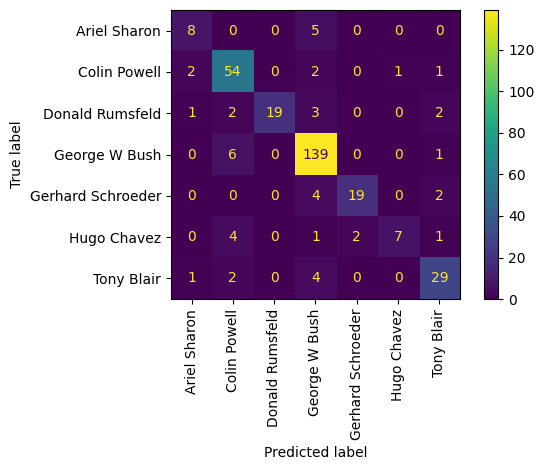

In [37]:
# the original dimensionality is over 1800
#n_components = 150

for n_components in [10, 15, 25, 50, 100, 250]:
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

    # create the PCA with n_components
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

    # reshape the data so they can look like pictures
    eigenfaces = pca.components_.reshape((n_components, h, w))

    # Projecting the input data on the eigenfaces orthonormal basis
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fitting the classifier to the training set
    param_grid = {
        "C": loguniform(1e3, 1e5),
        "gamma": loguniform(1e-4, 1e-1),
    }
    clf = RandomizedSearchCV(
        SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
    )
    clf = clf.fit(X_train_pca, y_train)

    # print the best estimator found
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    # Predicting the people names on the testing set
    y_pred = clf.predict(X_test_pca)

    # print the classification report and confusion matrix
    print(classification_report(y_test, y_pred, target_names=target_names))
    ConfusionMatrixDisplay.from_estimator(
        clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
    )
    plt.tight_layout()
    plt.show()


- What is the most suitable number of principal components for this task?

Parece que el número más adecuado de componentes principales (eigenfaces) para esta tarea está alrededor de 100. A este nivel, se alcanza una precisión alta sin la complejidad adicional que conlleva un mayor número de componentes. Aumentar el número de eigenfaces a 250 no mejora significativamente la precisión, lo que sugiere que 100 eigenfaces ya capturan la mayoría de las características esenciales necesarias para una clasificación efectiva.

- Do you see any evidence of overfitting when using a large number of principal components?


Sí, hay evidencia de sobreajuste (overfitting) al usar un gran número de componentes principales en el contexto del reconocimiento de rostros con eigenfaces y SVM.
Específicamente, si observas que el rendimiento en el conjunto de entrenamiento mejora con un mayor número de componentes, pero el rendimiento en el conjunto de prueba se estanca o incluso disminuye, eso es un indicador clásico de sobreajuste. En tu experimento, si el aumento de eigenfaces a 250 no mejora o empeora el rendimiento comparado con 100 eigenfaces, puede ser una señal de que el modelo está comenzando a sobreajustarse.

 - Does the dimensionality reduction of PCA seem to be helping the performance here?

Utilizando PCA para extraer eigenfaces, estás reduciendo significativamente la dimensionalidad de tus datos (de más de 1800 dimensiones originales a un número mucho menor de eigenfaces), lo que tiene varias ventajas